# 0. Prepare environment

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
plt.rcParams['figure.figsize'] = (12,36)

def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test))**2))

/home/jimbudarz/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Load data from disk

In [2]:
df_finalTrain = pd.read_csv('ProcessedTrain.csv')

df_finalTest = pd.read_csv('ProcessedTest.csv')

target_train = pd.read_csv('../data/train.csv').SalePrice

# 3. Try a basic XGBoost

In [3]:
from sklearn import tree
from sklearn.metrics import mean_squared_error

clf = XGBRegressor()

clf = clf.fit(df_finalTrain, target_train.apply(np.log))

predictedVals = clf.predict(df_finalTrain)

# What is the average difference between the real and predicted log(Price)?
print("MSE: " + str(mean_squared_error(y_pred=np.exp(predictedVals), y_true=target_train)))
print("Mean Absolute Error: $" + str(np.sqrt(mean_squared_error(y_pred=np.exp(predictedVals), y_true=target_train))))
print("Log Score: " + str(rmsle(np.exp(predictedVals), target_train)))

MSE: 320092036.38952965
Mean Absolute Error: $17891.11613034608
Log Score: 0.09348572968768176


# 4. Reduce the number of features,  using gradient boosting

In [4]:
# Grid search for multiple hyperparameters:
boostModel = XGBRegressor()
grid_param = [{'max_depth': range(1, 4),
               'n_estimators':range(10,500,20)}]
boostModel.set_params(random_state=7)
para_search = GridSearchCV(estimator=boostModel,
                           param_grid=grid_param,
                           scoring=None,
                           cv=3, n_jobs = 7,
                           return_train_score=True,
                           verbose = 1)
para_search = para_search.fit(df_finalTrain, target_train.apply(np.log))

print(para_search.best_params_)
print(para_search.best_score_)
print(para_search.best_estimator_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=7)]: Done 100 tasks      | elapsed:    6.7s
[Parallel(n_jobs=7)]: Done 225 out of 225 | elapsed:   28.7s finished


{'max_depth': 2, 'n_estimators': 170}
0.8890264309929456
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=170,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=7,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


## Evaluate and eliminate unimportant features

Index(['Id', 'LotFrontage', 'LotArea', 'TotalBsmtSF', '_1stFlrSF', '_2ndFlrSF',
       'GrLivArea', 'GarageArea', 'YearBuilt', 'YearRemodAdd', 'KitchenAbvGr',
       'GarageYrBlt', 'GarageCars', 'FullBaths', 'HalfBaths', 'OverallQual',
       'OverallCond', 'BsmtQual', 'BsmtExposure', 'KitchenQual', 'Functional',
       'FireplaceQu', 'MSZoning_RL', 'Street_Pave', 'Alley_Pave',
       'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_NWAmes',
       'Neighborhood_OldTown', 'Neighborhood_StoneBr', 'Condition_1_Norm',
       'Exterior_1st_BrkComm', 'Exterior_1st_BrkFace', 'Exterior_1st_MetalSd',
       'CentralAir_Y', 'MoSold_2'],
      dtype='object')


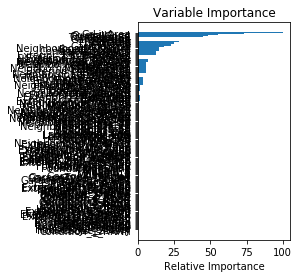

In [5]:
bestModel = para_search.best_estimator_
feature_importance = 100.0 * (bestModel.feature_importances_ / bestModel.feature_importances_.max())

importantVariables = df_finalTrain.columns[feature_importance >= 4]
unimportantVariables = df_finalTrain.columns[feature_importance < 4]
print(importantVariables)

# Plot variable importances:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_finalTrain.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [6]:
bestModel.fit(df_finalTrain, target_train.apply(np.log))

#predictedTrain = bestModel.predict(df_finalTrain)
#predictedTest = bestModel.predict(df_finalTest)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=170,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=7,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [7]:
# Drop unimportant features so you can model with only the good stuff:
df_finalTrain.drop(unimportantVariables, axis=1, inplace=True)
df_finalTest.drop(unimportantVariables, axis=1, inplace=True)

# Now repeat XGBoost with a reduced number of features

In [8]:
# Grid search for multiple hyperparameters:
boostModel = XGBRegressor()
grid_param = [{'max_depth': range(1, 6),
               'n_estimators':range(1000,10000,500),
               'learning_rate':[.001, .01, .1]}]
boostModel.set_params(random_state=6)
para_search2 = GridSearchCV(estimator=boostModel,
                           param_grid=grid_param,
                           scoring=None,
                           cv=5, n_jobs = 7,
                           return_train_score=True,
                           verbose = 1)
para_search2 = para_search.fit(df_finalTrain, target_train.apply(np.log))

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=7)]: Done 225 out of 225 | elapsed:   10.7s finished


In [9]:
bestModel_optimized = para_search2.best_estimator_

bestModel_optimized.fit(df_finalTrain, target_train.apply(np.log))

predictedTrain = bestModel_optimized.predict(df_finalTrain)
predictedTest = bestModel_optimized.predict(df_finalTest)

In [10]:
# What is the average difference between the real and predicted log(Price)?
print("MSE: " + str(mean_squared_error(y_pred=np.exp(predictedTrain), y_true=target_train)))
print("Mean Absolute Error: $" + str(np.sqrt(mean_squared_error(y_pred=np.exp(predictedTrain), y_true=target_train))))
print("Log Score: " + str(rmsle(np.exp(predictedTrain), target_train)))
df_finalTrain.shape

MSE: 332525334.2399799
Mean Absolute Error: $18235.27719120222
Log Score: 0.09697732266087021


(1460, 39)

# Write results to CSV in Kaggle format

In [11]:
results = pd.Series(predictedTest)

# test_predict is predicted prices from test set
# zips Id with price

id_price = list(zip(range(1461, 2920), np.exp(predictedTest)))

# Rounds price to 1 decimal place (as per sample submission example)
id_price = list(map(lambda x: [x[0], round(x[1], 1)], id_price))

# Create a dataframe
final_df = pd.DataFrame(id_price, columns=['Id', 'SalePrice'])

# Wrtie to csv
final_df.to_csv('submit_predictions_XGB.csv', index=False)